## Pipeline Level 2: Data Integration ##
This step integrates stocks and comments into a single dataframe at a daily interval.
The code is easily adaptable to other time intervals, but levels of specificity under daily intervals
Significantly ramp up the processing time.

Once Comments are built and combined. A TF-IDF is built and  saved to disk for Level 3 Operations

Functions:

**build_all_comments()**: Uses a loop to load individual subbreddit comments stored on disk (retrieved using Level 1 Pipelining).
                    Each CSV is concatinated into a single large dataframe.
                    
**build_Stocks()**: Loads daily closing prices from a single stock ticker symbol stored on disk (retrieved using Level 1 Pipelining).
              Stocks are loaded into a dataframe and the next day's stock price is added as a column for training.

**group_dataframe_by_time()**: Integrates the stock and comments into daily intervals. All comments are combined into a single string.

In [1]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform

import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
filepath = "./data/"
filename_suffix = "_comments.csv.zip"
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
def build_all_comments(subreddit,filepath,filename_suffix,keep_cols=['created_utc','score','total_awards_received','is_submitter','author_fullname','body']):

    import time
    
    start_time = time.time()

    #//*** Initialize Output dataframe
    output_df = pd.DataFrame()

    #//*** Load each Subreddit for Aggregation
    for subreddit in subreddits:
        #//*** Filepath + subreddit name + csv.zip
        input_filename = filepath+subreddit+filename_suffix

        print(f"Reading Compressed CSV: {input_filename}")

        #//*** Read Each DataFrame and combine with output_df
        output_df = pd.concat([output_df,pd.read_csv(input_filename,compression='zip' )])

    #//*** All Files read
    #//*** Reset the output_df index, since multiple indexes have been combined
    output_df.reset_index(drop=True, inplace=True)

    print(f"Files Loaded: {round(time.time()-start_time,2)}s")
    print(f"Total Records: {len(output_df)}")
    
    #//*** Ensure the body column is a string
    output_df['body'] = output_df['body'].astype('str')

    #//*** Convert UTC to date (not datetime)
    #//** Second pass goes from 12-21 to 4-19
    try:
        output_df['created_utc'] = output_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
    except:
        print()

    try:
        #//*** Keep just date and body fields
        output_df = output_df[keep_cols]
    except:
        print("Skipping Keep Cols")
        
    return output_df

def build_stocks(symbol,interval,targets):
    
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    for offset in targets:
        #//*** create a list of nan values of x length
        nan_list = list(np.empty( offset )* np.nan )

        #//*** Create target variable Price which is stocks + x columns in advance
        #//*** Takes the closing price starting at x and gets the remainder, this generates the offset
        #//*** nan_list fills the missing x values with nans
        target_list = nan_list + list(stock_df['close'])
        target_list.pop()
        stock_df[f'target_{offset}'] = target_list 

    stock_df = stock_df[:offset*-1]
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    #raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    #stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    

    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
    
    return stock_df
  
def group_dataframe_by_time(stock_df,cdf,symbol=None):
    groups = stock_df.groupby('time')

    #https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
    key_list = list(groups.groups.keys())

    out_df = pd.DataFrame()

    start_time = time.time()
    comment_min_time = raw_df['created_utc'].min()
    comment_max_time = raw_df['created_utc'].max()
    min_index = 0
    start_time = time.time()
    print("Processing...")
    for x in range(len(key_list)-1):

        #//*** Get a single line of stocks as a dataframe
        loop_stocks_df = groups.get_group((key_list)[x]).copy()  

        t1 = groups.get_group((key_list)[x])['time'].iloc[0]
        t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]

        #search through cdf to find comments that are between t1 and t2
        #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
        #temp_df = cdf.iloc[min_index:]
        temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]

        if len(temp_df) == 0:
                #//*** No COmments on this Date
                loop_stocks_df['body'] = " "
                loop_stocks_df['comment_count'] = 0
                loop_stocks_df['is_submitter'] = 0
                loop_stocks_df['score'] = 0 
                loop_stocks_df['total_awards_received'] = 0 
                loop_stocks_df['author_fullname'] = pd.Series(dtype=object)
        else:
            #print(temp_df.index[0])
            #print(temp_df.index[-1])
            #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
            temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
            #//*** Get all the body comments and combine them
            
            #//*** If symbol is NOT specified take all the comments
            if symbol == None:
                loop_stocks_df['body'] = " ".join(list(temp_df['body']))
            else:
                #//*** Symbol specified, only use comments that include the symbol
                
                if len(temp_df[temp_df['body'].str.contains(symbol)]) > 0:
                    symbol_body_df = temp_df[temp_df['body'].str.contains(symbol)]
                    #print(symbol_body_df)
                    loop_stocks_df['body'] = " ".join(list(symbol_body_df['body']))
                    #print(loop_stocks_df)
                    #if len(symbol_body_df[symbol_body_df['body'].str.find('symbol') > -1]):
                    #    print(symbol_body_df[symbol_body_df['body'].str.find('symbol') > -1])
                    #    break
                
            
            

            #//*** Get a comment count, BC IDK Y
            loop_stocks_df['comment_count'] = len(temp_df['body']) 
            
            loop_stocks_df['is_submitter'] = temp_df['is_submitter'].sum()
            
            loop_stocks_df['score'] = temp_df['score'].sum()
            
            loop_stocks_df['total_awards_received'] = temp_df['total_awards_received'].sum()
            
            loop_stocks_df['author_fullname'] = (temp_df['author_fullname'])
        #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
        #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
        if len(temp_df) > 0: 
            min_index = temp_df.index[-1]
            
        #print(temp_df)
        #print(temp_df.score.sum())
        #print(loop_stocks_df)
        #break

        #//*** Add the single line of loop_stocks_df to bin_df    
        out_df = pd.concat([out_df,loop_stocks_df])
            #print(loop_df.index)
            #print(loop_df)
            #cdf = cdf.drop(index=loop_df.index)
    print(f"Merge Built: {round(time.time()-start_time,2)}s")   
    return out_df

#model_df = group_dataframe_by_time(stock_df,raw_df,symbol)
#build_stocks(symbol,'daily',[1]).tail(25)

In [3]:
#//*** Get all Reddit Comments and merge into a single Collection

#process_tfidf = False

#//**** Aggregate comments into a single dataframe
raw_df = build_all_comments(subreddits,filepath,filename_suffix)

raw_df

#//*** Trim dataframe to start in January 20202-01-02
start_trim_date = pd.to_datetime("2020-01-02")
raw_df = raw_df[raw_df['created_utc'] >= start_trim_date]


Reading Compressed CSV: ./data/wallstreetbets_comments.csv.zip
Reading Compressed CSV: ./data/stocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsOGs_comments.csv.zip
Reading Compressed CSV: ./data/spacs_comments.csv.zip
Reading Compressed CSV: ./data/investing_comments.csv.zip
Reading Compressed CSV: ./data/pennystocks_comments.csv.zip
Reading Compressed CSV: ./data/stockmarket_comments.csv.zip
Reading Compressed CSV: ./data/options_comments.csv.zip
Reading Compressed CSV: ./data/robinhoodpennystocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsnew_comments.csv.zip
Reading Compressed CSV: ./data/smallstreetbets_comments.csv.zip
Files Loaded: 53.7s
Total Records: 4432533


In [20]:
raw_df

,created_utc,score,total_awards_received,is_submitter,author_fullname,body
11770,2020-01-31 13:56:13,1,0.0,True,t2_3yo4vdyj,I thought he didn’t kill people 🤔
11771,2020-01-31 13:56:17,1,0.0,True,t2_127kom,Looks like 4pm is where your chart ends at the...
11772,2020-01-31 13:56:19,1,0.0,True,t2_49f6b0hp,Notice how I said Trump’s America
11773,2020-01-31 13:56:21,1,0.0,True,t2_56mvp9vo,If trump is exhonerated this weekend 🚀🚀🚀
11774,2020-01-31 13:56:22,1,0.0,True,t2_15yfqh,Lol after yesterday I'm going monthly
...,...,...,...,...,...,...
4432528,2021-06-30 18:34:33,1,0.0,True,t2_8kmwyads,"Jun 30, 9.30pm EST.\n\n \nI just saw this pos..."
4432529,2021-06-30 19:08:36,1,0.0,False,t2_ah5dhj6a,Good run through. The mill is running and we’r...
4432530,2021-06-30 20:11:10,0,0.0,False,t2_6ypqa,Back to normal not there yet
4432531,2021-06-30 20:16:51,1,0.0,False,t2_9ypzayi0,💎👐🚀🚀🚀🚀


In [4]:
#//*** Build model_Ready Files using tfidf that only uses tfidf stock symbol mentions


from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#//**** Get all Stocks to Model
interval="daily"

#//*** Path to processed files

#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
#    output_filename = output_filename.replace("\\","/")
#    stock_ticker_filename = stock_ticker_filename.replace("\\","/")

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

#symbols = ["amc"]
f.close()

#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]

start_process_time = time.time()

for symbol in symbols:
    start_symbol_time = time.time()
    
    print("==========")
    print("==========")
    print("==========")
    print(f"Building {symbol} Targets...")
    #//*** Build stock price and target columns to predict
    stock_df = build_stocks(symbol,'daily',[1])  

    print(f"Dropping {symbol} dates before {start_trim_date}")
    stock_df = stock_df[stock_df['time'] >= start_trim_date]

    print(f"Dropping {symbol} dates after last comment {raw_df['created_utc'].iloc[-1]}")
    #//*** Remove stocks that are older than comments
    stock_df = stock_df[stock_df['time'] <= raw_df['created_utc'].iloc[-1]]
    
    print(f"Merging {symbol} with comments")
    #//*** Combine
    model_df = group_dataframe_by_time(stock_df,raw_df,symbol)
    
    #//*** Take all the comments
    #model_df = group_dataframe_by_time(stock_df,raw_df)
    
    model_df['body'] = model_df['body'].replace(np.nan, " ")
    
    tfidf = TfidfVectorizer()

    print(f"Begin {symbol} tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=10000)
    tfidf_matrix = tfidf.fit_transform(model_df['body'])
    print(f"tfidf Built: {round(time.time()-start_time,2)}s")
    
    print(f"Pickling {symbol} tfidf...")
    outfile = open(f"./ignore_folder/model_ready_{symbol}_{interval}_tfidf_.pkl","wb")
    pickle.dump(tfidf,outfile)
    outfile.close()
    print(f"Pickling {symbol} tfidf_matrix")
    outfile = open(f"./ignore_folder/model_ready_{symbol}_{interval}_tfidf_matrix.pkl","wb")
    pickle.dump(tfidf_matrix,outfile)
    outfile.close()
    
    print(f"Saving {symbol} stocks with target(s)")
    del model_df['body']
    del model_df['author_fullname']
    #//*** Drop the comments and comment count and save for modeling
    model_df.to_csv(f"./ignore_folder/model_ready_{symbol}_{interval}.csv.zip",compression="zip",index=False)
    
    print(f"{symbol} Processing Complete: {round(time.time()-start_symbol_time,2)}")
    

print (f"All Processing Complete : {round(time.time()-start_process_time,2)}s")

Building clov Targets...
Dropping clov dates before 2020-01-02 00:00:00
Dropping clov dates after last comment 2021-06-30 20:40:35
Merging clov with comments
Processing...
Merge Built: 13.49s
Begin clov tfidf....
tfidf Built: 0.13s
Pickling clov tfidf...
Pickling clov tfidf_matrix
Saving clov stocks with target(s)
clov Processing Complete: 14.41
Building sofi Targets...
Dropping sofi dates before 2020-01-02 00:00:00
Dropping sofi dates after last comment 2021-06-30 20:40:35
Merging sofi with comments
Processing...
Merge Built: 8.88s
Begin sofi tfidf....
tfidf Built: 0.1s
Pickling sofi tfidf...
Pickling sofi tfidf_matrix
Saving sofi stocks with target(s)
sofi Processing Complete: 9.52
Building wkhs Targets...
Dropping wkhs dates before 2020-01-02 00:00:00
Dropping wkhs dates after last comment 2021-06-30 20:40:35
Merging wkhs with comments
Processing...
Merge Built: 17.23s
Begin wkhs tfidf....
tfidf Built: 0.08s
Pickling wkhs tfidf...
Pickling wkhs tfidf_matrix
Saving wkhs stocks with t

## END of Primary Code ##
**Below is some TF-IDF graphs. Keeping them around for inspiration**

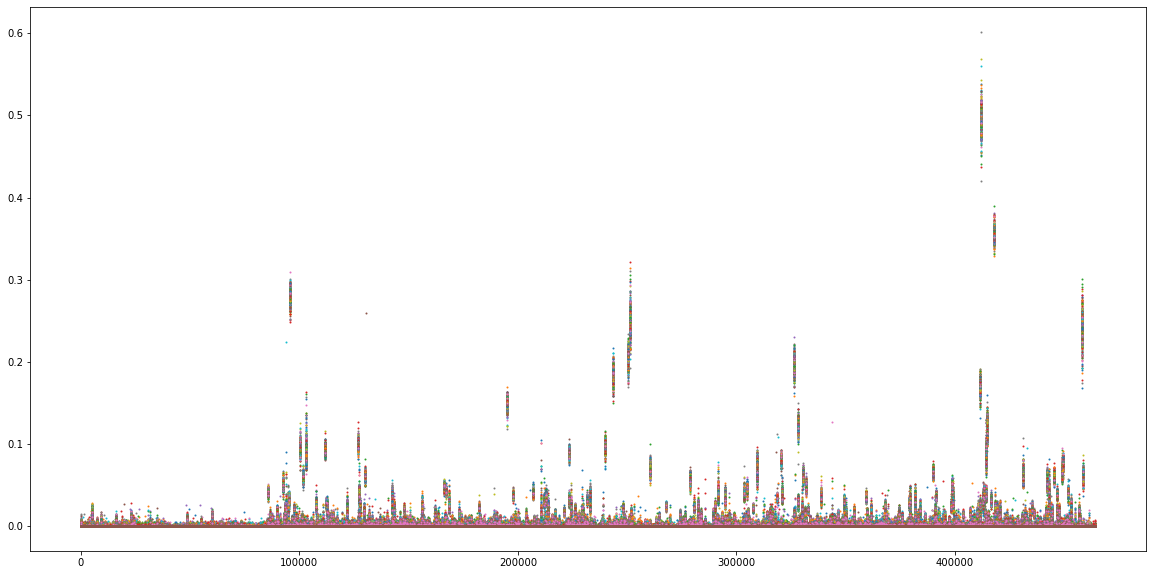

In [179]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(t[0]))
for x in t:
    ax.scatter(plot_x,x,s=1 )
plt.show()

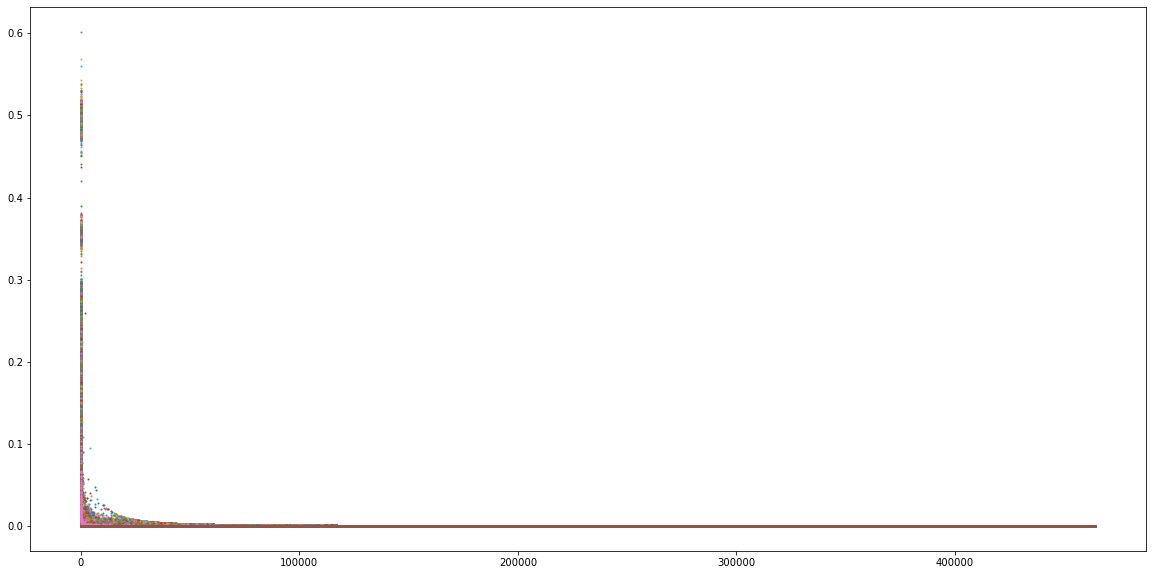

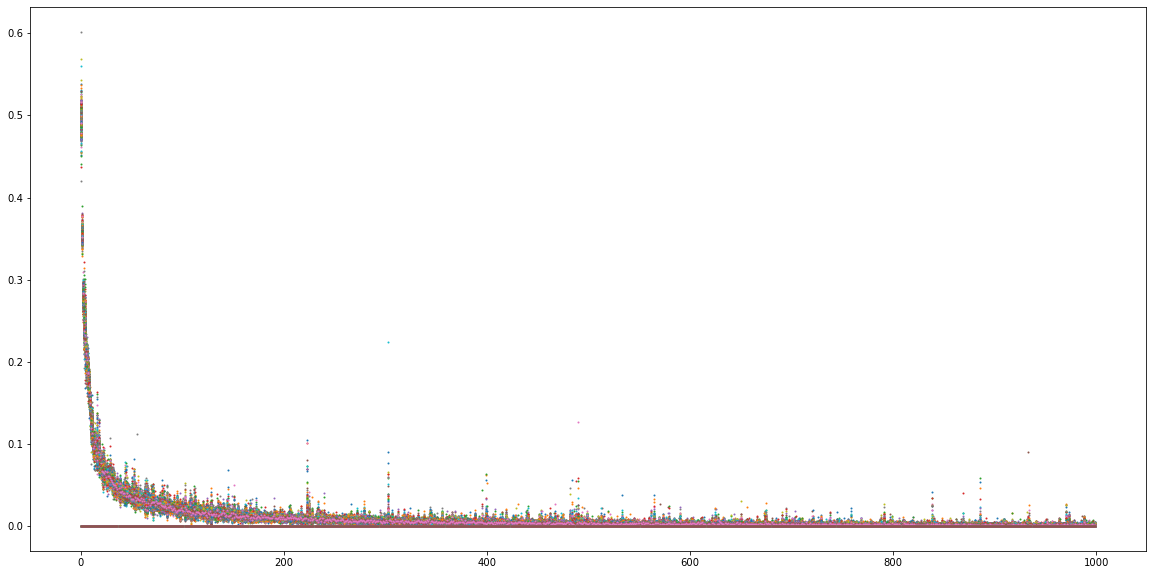

In [15]:
plot_df = tfidf_df[descending_vals]
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df.iloc[x],s=1 )
plt.show()


fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns[:1000]))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df[plot_df.columns[:1000]].iloc[x],s=1 )
plt.show()